## EDA for videos

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import cv2 as cv

import downloader as d 
import video as v

from typing import Tuple, Union
from numpy.typing import NDArray
from dataclasses import dataclass
from collections import deque

from importlib import reload

In [8]:
pd.options.display.float_format = '{:,.2f}'.format

### Part I. Videos with epilepcy warnings.

Pokemon video: flashes 
- on the second 10 
- from 13 till 19 seconds
- in the end of the video: around 25-26 second

In [50]:
video1 = v.get_exploration_df('videos/Banned Pokemon Seizure Scene.mp4')

In [38]:
video1.head(2)

hue  lightness  saturation  masked_values  seconds
frame y x                                                    
0     0 0    0         36           0              0        0
        1    0         34           0              0        0

In [39]:
video1.shape

(7850000, 5)

In [42]:
fps = video1.attrs['fps']

#### 1. Lightness per second vs Lightness per frame
How differ lightness per second from lightness per frame?

/var/folders/1h/vmdz8n3d00lfsp1hw8300jt00000gn/T/ipykernel_50757/3338889377.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks() // fps)


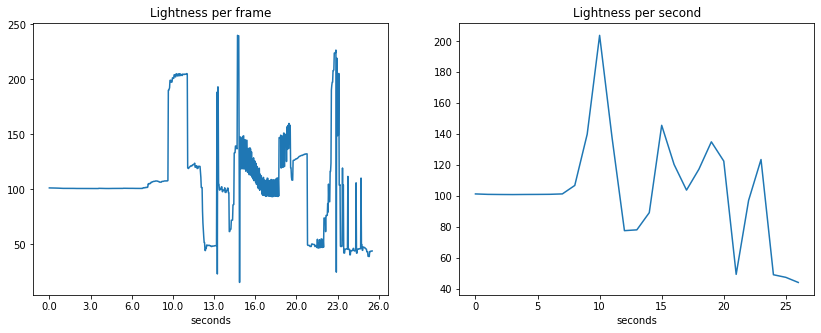

In [44]:
plt.figure(figsize=(14,5))
plt.subplot(121)
ax1 = video1.groupby('frame').lightness.mean().plot()
plt.title('Lightness per frame')
ax1.set_xticklabels(ax1.get_xticks() // fps)
ax1.set_xlabel('seconds')
plt.subplot(122)
video1.groupby('seconds').lightness.mean().plot()
plt.title('Lightness per second')
plt.show()

__Takeaway:__
- Seconds show lightness changes but don't show all changes like frames do

#### 2. How the lightness changes from frame to frame?

In [60]:
cdf1 = v.get_aggregated_df(video1)

In [64]:
cdf1.describe()[1:]

,lightness,hue,saturation,masked_values,light_diff,hue_diff,saturation_diff,mask_diff
mean,105.42,90.75,111.39,"2,089.83",0.07,-0.03,0.04,1.92
std,41.93,30.97,38.13,"2,348.08",20.85,16.68,12.00,"1,098.63"
min,15.48,18.13,20.47,117.00,-194.26,-155.84,-115.15,"-9,834.00"
25%,96.88,83.67,92.50,225.00,-0.07,-0.15,-0.15,-2.00
50%,100.99,92.95,93.58,"1,646.00",0.00,0.00,0.00,0.00
75%,119.54,101.18,134.53,"2,700.00",0.04,0.15,0.27,2.00
max,240.02,174.23,237.17,"9,963.00",201.82,135.48,102.00,"9,839.00"


In [62]:
cdf1.head(1)

,lightness,hue,saturation,masked_values,light_diff,hue_diff,saturation_diff,mask_diff
frame,,,,,,,,
0,101.38,93.92,91.99,"1,643.00",NaN,NaN,NaN,NaN


In [67]:
video1.attrs['fps']

30

/var/folders/1h/vmdz8n3d00lfsp1hw8300jt00000gn/T/ipykernel_50757/820829273.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks() // fps)
/var/folders/1h/vmdz8n3d00lfsp1hw8300jt00000gn/T/ipykernel_50757/820829273.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax1.get_xticks() // fps)


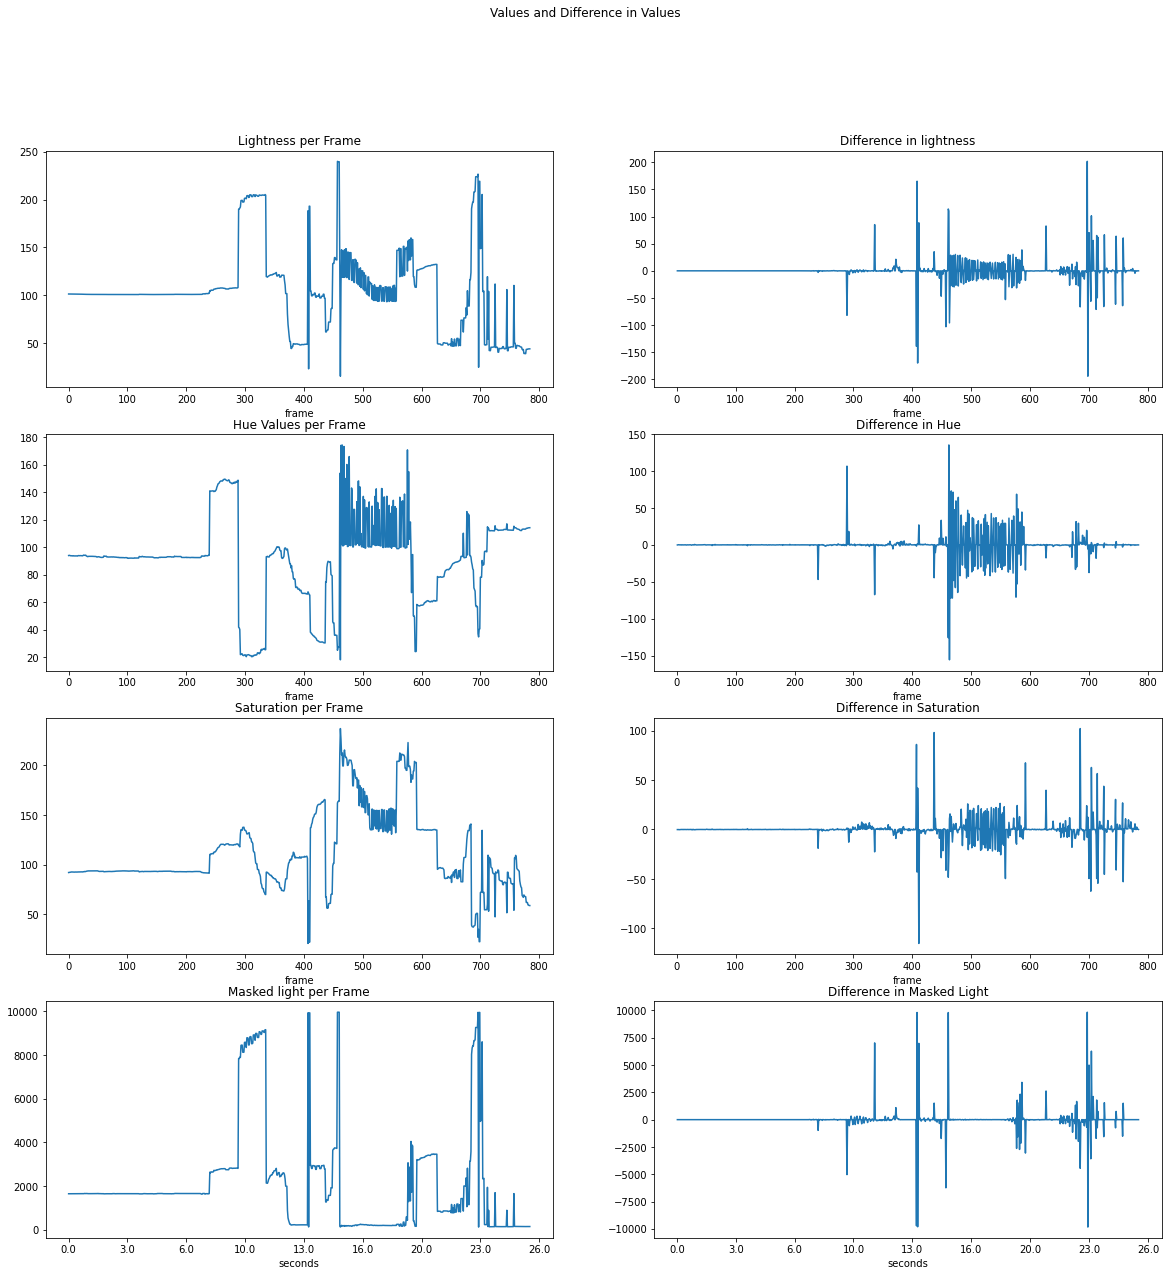

In [68]:
fps = video1.attrs['fps']

plt.figure(figsize=(20, 20))
plt.suptitle('Values and Difference in Values')

plt.subplot(421)
cdf1.lightness.plot()
plt.title('Lightness per Frame')

plt.subplot(422)
cdf1.light_diff.plot()
plt.title('Difference in lightness')

plt.subplot(423)
cdf1.hue.plot()
plt.title('Hue Values per Frame')

plt.subplot(424)
cdf1.hue_diff.plot()
plt.title('Difference in Hue')

plt.subplot(425)
cdf1.saturation.plot()
plt.title('Saturation per Frame')

plt.subplot(426)
cdf1.saturation_diff.plot()
plt.title('Difference in Saturation')

plt.subplot(427)
ax1 = cdf1.masked_values.plot()
plt.title('Masked light per Frame')
ax1.set_xticklabels(ax1.get_xticks() // fps)
ax1.set_xlabel('seconds')

plt.subplot(428)
ax2 = cdf1.mask_diff.plot()
plt.title('Difference in Masked Light')
ax2.set_xticklabels(ax1.get_xticks() // fps)
ax2.set_xlabel('seconds')

plt.show()

The best values to capture the change between frames are:
- difference in lightness
- difference in hue

#### 3. Will the product of lightness, hue and saturation give us a better picture of changes?

In [77]:
cdf1['hs_product'] = cdf1.hue * cdf1.saturation
#cdf1['product'] = cdf1.lightness * cdf1.hs_product

In [78]:
cdf1.head()

,lightness,hue,saturation,masked_values,light_diff,hue_diff,saturation_diff,mask_diff,product,hs_product
frame,,,,,,,,,,
0,101.38,93.92,91.99,"1,643.00",NaN,NaN,NaN,NaN,"875,946.98","8,639.89"
1,101.38,94.03,92.08,"1,643.00",0.00,-0.11,-0.09,0.00,"877,802.53","8,658.40"
2,101.35,93.97,92.17,"1,643.00",0.03,0.06,-0.09,0.00,"877,804.79","8,660.79"
3,101.33,93.77,92.24,"1,642.00",0.02,0.20,-0.07,1.00,"876,424.26","8,649.03"
4,101.29,93.72,92.43,"1,642.00",0.04,0.05,-0.19,0.00,"877,492.13","8,662.76"
